#### Comparison of the enriched TxPs with the RF feature importances

Prepared by: Grace Patlewicz <br>
Modified: 26 January 2023 <br>
Changes: Since the TxPs were revised based on an FR correction - the number and identity of the enriched TxPs have changed. <br>
Notes: scikit-024 was used in the model development - pls ensure that this version is used when attempting to make predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import openpyxl
%matplotlib inline

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
import pickle

In [4]:
filename = 'finalized_model_v2.sav'
final_model = pickle.load(open(external_dir+filename, 'rb'))


In [5]:
final_model

RandomForestClassifier(max_leaf_nodes=50, max_samples=0.66, n_estimators=50,
                       random_state=42)

In [7]:
len(final_model.feature_importances_)

271

In [11]:
features1 = list(pd.read_csv(external_dir+'Xtrain1_190922.csv').iloc[:,1:].columns)

In [12]:
feature_importances1 = pd.DataFrame({'feature': features1, 'importance': final_model.feature_importances_})
feature_importances1.head()

,feature,importance
0,atom:element_metal_group_I_II,0.001586
1,atom:element_metal_metalloid,0.000475
2,atom:element_metal_transistion_metal,0.000752
3,bond:C#N_nitrile_generic,0.000707
4,bond:C#N_nitrile,0.000365


In [13]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    Credit to Will Koehrsen  -  https://www.kaggle.com/code/willkoehrsen/a-complete-introduction-and-walkthrough 
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

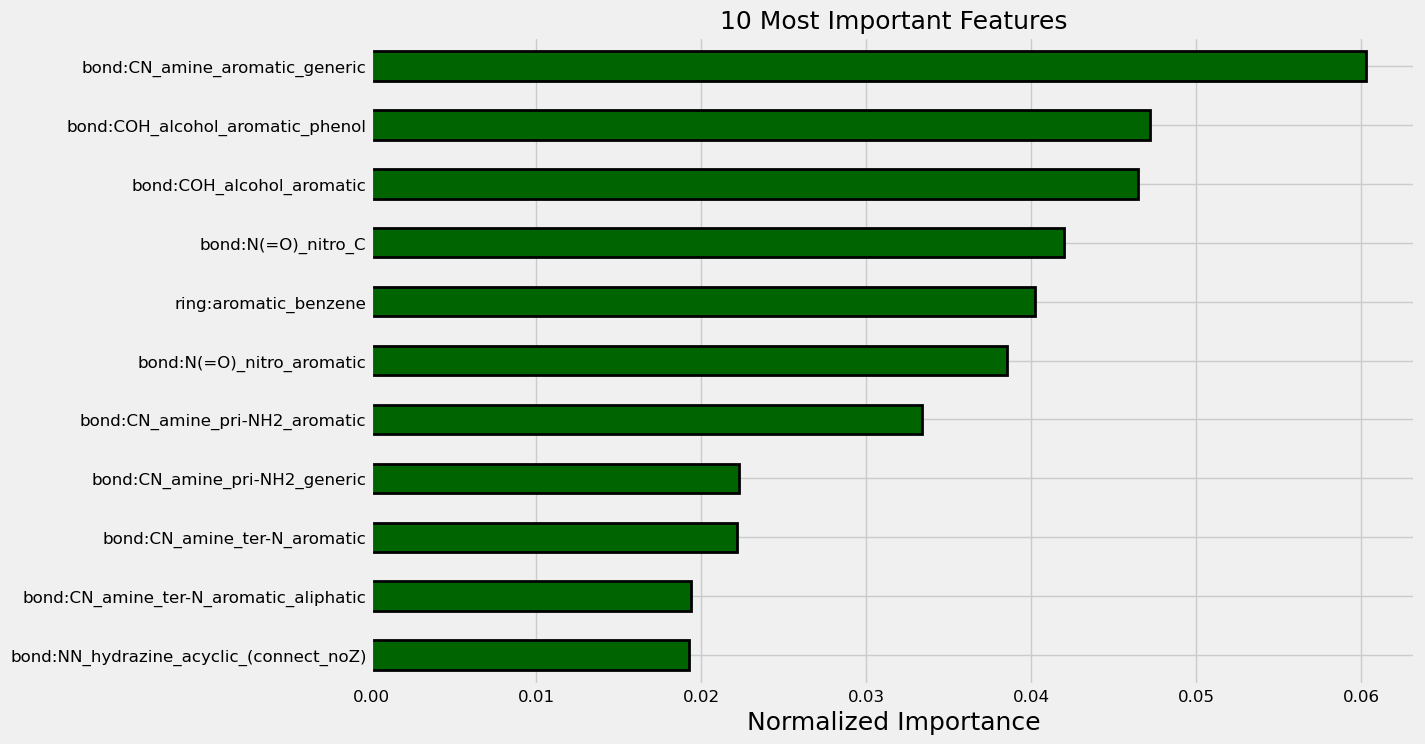

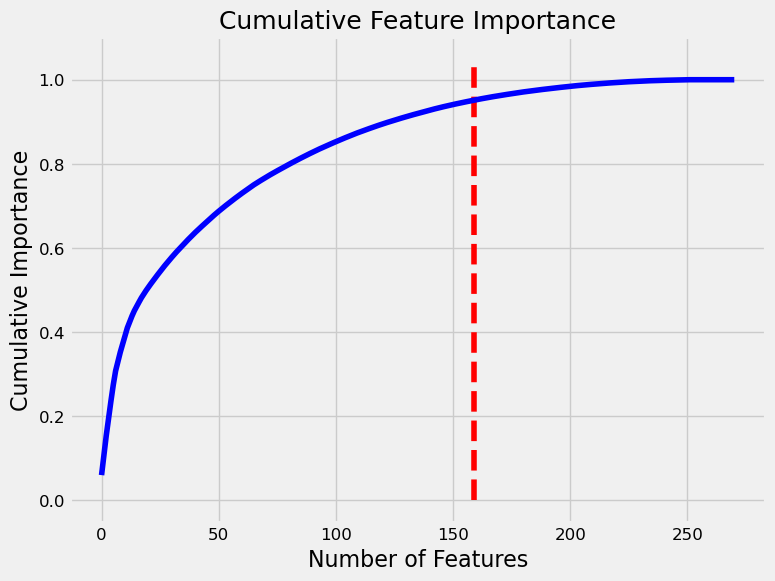

159 features required for 95% of cumulative importance.


In [14]:
norm_fi1 = plot_feature_importances(feature_importances1, threshold=0.95)

In [15]:
feats = norm_fi1[norm_fi1['cumulative_importance'] <0.95]['feature'].tolist()

In [19]:
enriched = pd.read_csv(interim_dir+'enriched_TxPs_250123.csv')

In [23]:
enriched.shape

(47, 12)

In [20]:
enriched_txps = enriched['TxP'].tolist()

In [21]:
len(enriched_txps)

47

In [25]:
len([e for e in enriched_txps if e in feats])

28

Still the same number of enriched TxPs that overlap. 